# FIAP - Challenge Ingredion – SPRINT 3 - Group 16

## 1 Machine Learning

Este notebook implementa um fluxo completo de Machine Learning para previsão de produtividade agrícola, integrando dados de satélite (NDVI) e 
históricos de produção. As principais libs para construcao e implementacao do modelo.

Utilizando o PyTorch para construção de modelos MLP e LSTM e otimização de hardware (GPU via CUDA, quando disponível). A estrutura inclui: pré-processamento avançado de séries temporais, normalização de dados, criação de janelas temporais customizadas, treinamento supervisionado com validação cruzada temporal e avaliação comparativa de modelos. A definição explícita do dispositivo (device) assegura que operações tensoriais sejam aceleradas por GPU, essencial para treinar redes neurais complexas com eficiência.

### 1.1 Importando Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import os
from datetime import datetime
from typing import Tuple

from tqdm import trange

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### 1.2 Setup

In [2]:
torch.manual_seed(1)
np.random.seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1.3 Carrendo Caminho de Dados Processados

In [3]:
NDVI_PATH = "../data/PROCESSED/ndvi.csv"
PROD_PATH = "../data/PROCESSED/manhuacu.csv"

MLP_MODEL_PATH = "../models/mlp.pth"
LSTM_MODEL_PATH = "../models/lstm.pth"

### 1.4 Hiperparâmetros

In [4]:
# MLP Hyperparameters
MLP_WINDOW_SIZE = 5
MLP_BATCH_SIZE = 4
MLP_BASE_HIDDEN_SIZE = 32
MLP_DROPOUT = 0.12
MLP_EPOCHS = 300
MLP_LEARNING_RATE = 2e-3

# LSTM Hyperparameters
LSTM_WINDOW_SIZE = 6
LSTM_HIDDEN_SIZE = 21
LSTM_NUM_LAYERS = 2
LSTM_DROPOUT = 0.1355
LSTM_EPOCHS = 200
LSTM_BATCH_SIZE = 8
LSTM_LEARNING_RATE = 5e-3

# Computation
LSTM_DROPOUT = LSTM_DROPOUT if LSTM_NUM_LAYERS > 1 else 0

### 1.5 Carregando e Pré-processando os Dados

#### 1.5.1 Preservando a Natureza Cíclica dos Dados Temporais

Este bloco implementa uma técnica para transformar datas em representações numéricas que preservam a natureza cíclica do tempo. As funções convertem:

1. Datas em posições angulares ao longo do ano (via seno/cosseno)
2. Tratam automaticamente anos bissextos
3. Geram saídas normalizadas que evitam descontinuidades entre dezembro/janeiro

**Testes de exemplo** mostram a conversão para três datas-chave:
- 01/01: início do ciclo (0.0, 1.0)
- 01/06: meio do ano (0.5, 0.0) 
- 31/12: fim do ciclo (~1.0, ~1.0)

A abordagem é ideal para modelos de ML que precisam entender padrões sazonais em dados temporais.

In [5]:
def get_day_of_year_index(date: datetime):
    """Convert date to day of year."""
    return datetime(date.year, date.month, date.day).timetuple().tm_yday - 1


def get_sin_cos(x: float):
    """Convert x to sin and cos."""
    rad = 2 * np.pi * x
    return (np.sin(rad), np.cos(rad))


def encode_date(date: datetime):
    is_leap_year = 1 if date.year % 4 == 0 else 0
    total_year_days = 366 if is_leap_year else 365
    day_index = get_day_of_year_index(date)
    return get_sin_cos(day_index / total_year_days)


# Test
print("Encoding date 2020-01-01")
print(encode_date(datetime(2020, 1, 1)))  # (0.0, 1.0)
print("\n")
print("Encoding date 2020-06-01")
print(encode_date(datetime(2020, 6, 1)))  # (0.5, 0.0)
print("\n")
print("Encoding date 2020-12-31")
print(encode_date(datetime(2020, 12, 31)))  # (0.9999999999999999, 1.0)
print("\n")

Encoding date 2020-01-01
(0.0, 1.0)


Encoding date 2020-06-01
(0.5074150932938454, -0.8617017599480682)


Encoding date 2020-12-31
(-0.017166329754707492, 0.9998526477050269)




#### 1.5.2 Processamento de Dados de Produtividade

**Essa padronização é crucial para os modelos MLP e LSTM**, realizando a codificação cíclica preserva sazonalidades que as redes neurais podem aprender, a filtragem temporal garante consistência com os dados agrícolas e a ordenação é essencial para o funcionamento correto das janelas temporais usadas nas LSTMs.

**Pré-processamento do NDVI:** Carrega os dados de vegetação, adiciona contagem de observações anuais, aplica codificação cíclica às datas, filtra o período (2000-2023) e ordena cronologicamente. 

In [6]:
NDVI = pd.read_csv(NDVI_PATH)

NDVI["N_Observations"] = NDVI.groupby("Year")["Data"].transform("count")

NDVI[["Date_sin", "Date_cos"]] = NDVI["Data"].apply(
    lambda x: pd.Series(encode_date(datetime.strptime(x, "%Y-%m-%d")))
)

# Assert order by Data (ascending)
NDVI = NDVI.sort_values(by="Data", ascending=True)

NDVI = NDVI[(NDVI["Year"] >= 2000) & (NDVI["Year"] <= 2023)]

NDVI.head()

,Data,NDVI,Year,N_Observations,Date_sin,Date_cos
0,2000-02-18,0.482058,2000,20,0.733885,0.679273
1,2000-03-05,0.476160,2000,20,0.890617,0.454755
2,2000-03-21,0.483806,2000,20,0.980575,0.196143
3,2000-04-06,0.495976,2000,20,0.997018,-0.077175
4,2000-04-22,0.468606,2000,20,0.938710,-0.344707


#### 1.5.3 Pré-processando os Dados de Produção

Carrega os dados agrícolas e filtra o período entre 2000-2023 para manter consistência temporal com os dados de NDVI. Essa etapa é fundamental para garantir que os modelos MLP e LSTM trabalhem com o mesmo intervalo temporal, permitindo correlações precisas entre produtividade e índices de vegetação ao longo dos anos. O código comentado mostra uma opção de normalização que poderia ser utilizada para escalar os valores entre 0 e 1.

In [7]:
PROD = pd.read_csv(PROD_PATH)
PROD = PROD[(PROD["Year"] >= 2000) & (PROD["Year"] <= 2023)]
# max_productivity = PROD["Productivity (kg/ha)"].max()
# PROD["Normalized_productivity"] = PROD["Productivity (kg/ha)"] / max_productivity
PROD.head()

,Year,Production (kg),Area (ha),Productivity (kg/ha)
26,2000,17424000,13200,1320.0
27,2001,17424000,13200,1320.0
28,2002,26325000,17550,1500.0
29,2003,13533000,17350,780.0
30,2004,16560000,17250,960.0


### 1.6 Preparar Datasets

#### 1.6.1 **Normalização dos Dados de NDVI e Produtividade**

**Objetivo:**  

Padronizar as escalas das features para otimizar o treinamento dos modelos MLP e LSTM.

**Processo realizado:**

1. **NDVI:**
   - Aplica `StandardScaler` nas colunas NDVI e Year
   - Transforma valores originais (NDVI: -1 a 1, Year: 2000-2023) para escala padrão (média=0, std=1)

2. **Produtividade:**
   - Normaliza "Productivity (kg/ha)" e Year usando mesma abordagem
   - Mantém consistência com a normalização do NDVI para o ano

**Por que é essencial?**

- Garante que todas as features contribuam igualmente para o aprendizado
- Acelera a convergência dos modelos neurais
- Permite comparação direta entre:
  - Dados de vegetação (NDVI)
  - Dados agrícolas (Produtividade)
- Criticamente importante para:
  - Algoritmos sensíveis à escala (redes neurais)
  - Integração de múltiplas fontes de dados temporais

**Resultado Final:**

- `NDVI[["NDVI_norm", "Year_norm"]]`: Features padronizadas para o modelo
- `PROD[["Productivity_norm", "Year_norm"]]`: Variável alvo normalizada
- Compatibilidade total entre os conjuntos de dados

In [8]:
# Normalizer dados NDVI
NDVI["Year_norm"] = NDVI["Year"].copy()

ndvi_scaler = StandardScaler().fit(NDVI[["NDVI", "Year"]].values)
NDVI[["NDVI_norm", "Year_norm"]] = ndvi_scaler.transform(NDVI[["NDVI", "Year"]].values)

NDVI.head()

,Data,NDVI,Year,N_Observations,Date_sin,Date_cos,Year_norm,NDVI_norm
0,2000-02-18,0.482058,2000,20,0.733885,0.679273,-1.678564,1.290739
1,2000-03-05,0.476160,2000,20,0.890617,0.454755,-1.678564,1.201752
2,2000-03-21,0.483806,2000,20,0.980575,0.196143,-1.678564,1.317123
3,2000-04-06,0.495976,2000,20,0.997018,-0.077175,-1.678564,1.500766
4,2000-04-22,0.468606,2000,20,0.938710,-0.344707,-1.678564,1.087770


In [9]:
# Normalizar produtividade
PROD["Year_norm"] = NDVI["Year"].copy()

prod_scaler = StandardScaler().fit(PROD[["Productivity (kg/ha)", "Year"]].values)
PROD[["Productivity_norm", "Year_norm"]] = prod_scaler.transform(
    PROD[["Productivity (kg/ha)", "Year"]].values
)
PROD.head()

,Year,Production (kg),Area (ha),Productivity (kg/ha),Year_norm,Productivity_norm
26,2000,17424000,13200,1320.0,-1.661325,0.425926
27,2001,17424000,13200,1320.0,-1.516862,0.425926
28,2002,26325000,17550,1500.0,-1.372399,1.171894
29,2003,13533000,17350,780.0,-1.227936,-1.811979
30,2004,16560000,17250,960.0,-1.083473,-1.066011


#### 1.6.2 Estruturação de Dados Temporais

**Funcionamento do Dataset**

O `DatasetYearOfLast` cria sequências temporais fixas (janelas) de medições de NDVI, associando cada janela à produtividade do ano do último dado na sequência. As janelas respeitam a continuidade temporal, ficando dentro do mesmo ano ou no ano seguinte imediato, garantindo coerência nos padrões sazonais e tendências.

**Divisão Temporal e Uso**

Os dados são divididos em treino, validação e teste com base em anos específicos, simulando a previsão real onde o modelo aprende com dados passados e é avaliado em anos futuros. O dataset também permite extrair a última janela de qualquer ano para análises focadas no período mais recente.

Essa estrutura é ideal para modelos sequenciais como LSTM, pois mantém a ordem temporal e captura a sazonalidade essencial para previsões agrícolas.


In [10]:
class DatasetYearOfLast(torch.utils.data.Dataset):
    def __init__(self, ndvi_df, prod_df, window_size=LSTM_WINDOW_SIZE):
        self.ndvi_df = ndvi_df.copy().reset_index(drop=True)
        self.window_size = window_size
        self.prod_df = prod_df

        # Prepare windows grouped by year
        self.samples = []
        self.available_years = ndvi_df["Year"].unique().tolist()

        for idx, row in self.ndvi_df.iterrows():
            window = ndvi_df.iloc[idx : idx + window_size]

            if len(window) < window_size:
                break

            last_of_window = self.ndvi_df.iloc[idx + window_size - 1]

            if last_of_window["Year"] == row["Year"] or (
                last_of_window["Year"] == row["Year"] + 1
                and row["Year"] + 1 in self.available_years
            ):
                self.samples.append((window, last_of_window["Year"]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        window, year = self.samples[idx]
        ndvi = window[["NDVI", "Date_sin", "Date_cos", "Year_norm"]].values

        prod = self.prod_df[self.prod_df["Year"] == year]["Productivity_norm"].values[0]

        return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
            prod, dtype=torch.float32
        )

    def get_last_window_of_year(self, year) -> Tuple[np.ndarray, np.ndarray]:
        """
        Retorna a última janela do ano
        """

        ndvi = self.ndvi_df[self.ndvi_df["Year"] == year]
        if ndvi.empty:
            raise ValueError(f"Year {year} not found in dataset")
        if len(ndvi) < self.window_size:
            raise ValueError(
                f"Year {year} has only {len(ndvi)} observations, less than window size {self.window_size}"
            )
        return (
            ndvi.iloc[-self.window_size :][
                ["NDVI", "Date_sin", "Date_cos", "Year_norm"]
            ].values,
            self.prod_df[self.prod_df["Year"] == year]["Productivity_norm"].values[0],
        )


years_validation = [2004, 2010, 2016, 2022]
years_test = [2005, 2011, 2017, 2023]
years_train = PROD[~PROD["Year"].isin(years_validation + years_test)]["Year"].unique()
years_train = sorted(years_train)


# Datasets better
mlp_train_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_train)], PROD, MLP_WINDOW_SIZE
)
mlp_validation_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_validation)], PROD, MLP_WINDOW_SIZE
)
mlp_test_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, MLP_WINDOW_SIZE
)

lstm_train_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_train)], PROD, LSTM_WINDOW_SIZE
)
lstm_validation_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_validation)], PROD, LSTM_WINDOW_SIZE
)
lstm_test_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, LSTM_WINDOW_SIZE
)


print(mlp_validation_dataset[0])
print("\n")
print(mlp_validation_dataset.get_last_window_of_year(2004))

(tensor([[ 0.4331,  0.0000,  1.0000, -1.0979],
        [ 0.4789,  0.2712,  0.9625, -1.0979],
        [ 0.3686,  0.5221,  0.8529, -1.0979],
        [ 0.4699,  0.7339,  0.6793, -1.0979],
        [ 0.4688,  0.8906,  0.4548, -1.0979]]), tensor(-1.0660))


(array([[ 0.37612524, -0.97326437,  0.22968774, -1.09788864],
       [ 0.36308863, -0.87448096,  0.48505985, -1.09788864],
       [ 0.41959682, -0.71013502,  0.70406552, -1.09788864],
       [ 0.34801154, -0.49254807,  0.87028524, -1.09788864],
       [ 0.48473122, -0.23803328,  0.971257  , -1.09788864]]), -1.0660107587499457)


**Divisão temporal em janelas**

Os dados vão de 2000 a 2023 e são divididos em blocos de 6 anos consecutivos:

* 4 primeiros anos para treino
* 5º ano para validação
* 6º ano para teste

Essas janelas se repetem ao longo do tempo, criando múltiplos períodos de treino, validação e teste que se sobrepõem parcialmente.

**Vantagens dessa abordagem para previsão agrícola**

* Respeita a ordem temporal, evitando que o modelo “veja o futuro” durante o treino.
* Avalia o desempenho do modelo em diferentes períodos, capturando variações climáticas e sazonais.
* Facilita o aprendizado de padrões sazonais e tendências de longo prazo do NDVI e produtividade.
* Simula o cenário real de prever o futuro a partir do passado.

**Comparação com divisão percentual simples**

Dividir os dados em 75% primeiros dados para treino, 12,5% seguintes para validação e 12,5% últimos para teste é uma alternativa à divisão em blocos. No entanto, pode ser inadequado para previsões em séries temporais porque:

* Avalia o modelo em apenas um período futuro, limitando a análise.
* Pode cortar ciclos sazonais importantes, gerando dados de treino não representativos.
* Pode permitir vazamento temporal, com dados futuros “vazando” para treino, resultando em avaliação otimista.

**Considerações**

Essa divisão em janelas permite tuning do modelo em dados próximos ao futuro e teste real em dados ainda mais à frente, evitando overfitting. É alinhada com a validação progressiva (walk-forward), e gerencia bem a sazonalidade e equilíbrio temporal, garantindo modelos robustos e aplicáveis na previsão agrícola.


In [11]:
years_validation = [2004, 2010, 2016, 2022]
years_test = [2005, 2011, 2017, 2023]
years_train = PROD[~PROD["Year"].isin(years_validation + years_test)]["Year"].unique()
years_train = sorted(years_train)


# Datasets better
mlp_train_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_train)], PROD, MLP_WINDOW_SIZE
)
mlp_validation_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_validation)], PROD, MLP_WINDOW_SIZE
)
mlp_test_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, MLP_WINDOW_SIZE
)

lstm_train_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_train)], PROD, LSTM_WINDOW_SIZE
)
lstm_validation_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_validation)], PROD, LSTM_WINDOW_SIZE
)
lstm_test_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, LSTM_WINDOW_SIZE
)


print(mlp_validation_dataset[0])
print("\n")
print(mlp_validation_dataset.get_last_window_of_year(2004))

(tensor([[ 0.4331,  0.0000,  1.0000, -1.0979],
        [ 0.4789,  0.2712,  0.9625, -1.0979],
        [ 0.3686,  0.5221,  0.8529, -1.0979],
        [ 0.4699,  0.7339,  0.6793, -1.0979],
        [ 0.4688,  0.8906,  0.4548, -1.0979]]), tensor(-1.0660))


(array([[ 0.37612524, -0.97326437,  0.22968774, -1.09788864],
       [ 0.36308863, -0.87448096,  0.48505985, -1.09788864],
       [ 0.41959682, -0.71013502,  0.70406552, -1.09788864],
       [ 0.34801154, -0.49254807,  0.87028524, -1.09788864],
       [ 0.48473122, -0.23803328,  0.971257  , -1.09788864]]), -1.0660107587499457)


#### 1.6.3 Validação de Consistência dos Dados

**Verificação de Integridade:**  
Realiza um teste de sanidade comparando diretamente:  
1. Os últimos 20 registros de NDVI de 2017 do DataFrame original  
2. A mesma janela temporal extraída pelo `DatasetYearOfLast`  
3. Os valores de produtividade (original e normalizado)  

Inclui um assert para garantir que os valores coincidam exatamente, validando a correta implementação do pré-processamento e da lógica de janelas temporais.

In [12]:
# Sanity check
print("Last window of 2017 in the DataFrame:")
print(
    NDVI[NDVI["Year"] == 2017][["NDVI", "Date_sin", "Date_cos", "Year_norm"]].tail(
        LSTM_WINDOW_SIZE
    )
)

print(
    f"\nProdutivity 2017: {PROD[PROD['Year'] == 2017]['Productivity (kg/ha)'].values[0]}"
)
print(
    f"Produtivity 2017 (normalized): {PROD[PROD['Year'] == 2017]['Productivity_norm'].values[0]}"
)

print(f"\nLast window of 2017 in the DatasetYearOfLast (values should match exactely):")
print(lstm_test_dataset.get_last_window_of_year(2017))

assert (
    lstm_test_dataset.get_last_window_of_year(2017)[0]
    == NDVI[NDVI["Year"] == 2017][["NDVI", "Date_sin", "Date_cos", "Year_norm"]]
    .tail(LSTM_WINDOW_SIZE)
    .values
).all(), "\n❌ Sanity check failed! Please check the DatasetYearOfLast class"
print(
    "\n✅ Sanity check passed for LSTM! You can look values by yourself if you want to double check."
)

Last window of 2017 in the DataFrame:
         NDVI  Date_sin  Date_cos  Year_norm
405  0.323114 -0.999546 -0.030120   0.789306
406  0.339417 -0.970064  0.242850   0.789306
407  0.417126 -0.867456  0.497513   0.789306
408  0.377441 -0.699458  0.714673   0.789306
409  0.446337 -0.478734  0.877960   0.789306
410  0.400471 -0.221922  0.975065   0.789306

Produtivity 2017: 1433.3878887070375
Produtivity 2017 (normalized): 0.895835237016665

Last window of 2017 in the DatasetYearOfLast (values should match exactely):
(array([[ 0.3231135 , -0.99954628, -0.0301203 ,  0.78930578],
       [ 0.3394167 , -0.97006392,  0.24284972,  0.78930578],
       [ 0.41712597, -0.86745635,  0.49751329,  0.78930578],
       [ 0.37744055, -0.69945833,  0.71467339,  0.78930578],
       [ 0.44633691, -0.47873384,  0.87796008,  0.78930578],
       [ 0.40047079, -0.22192151,  0.97506453,  0.78930578]]), 0.895835237016665)

✅ Sanity check passed for LSTM! You can look values by yourself if you want to double check.


#### 1.6.4. Inspeção visual dos dados


##### 1.6.4.1. Features de entrada ao longo do tempo

- NDVI (normalizado): permite verificar a sazonalidade
- Date_sin e Date_cos(dia do ano): ajudam a entender a periodicidade dos dados
- Year (normalizado): mostra a evolução temporal


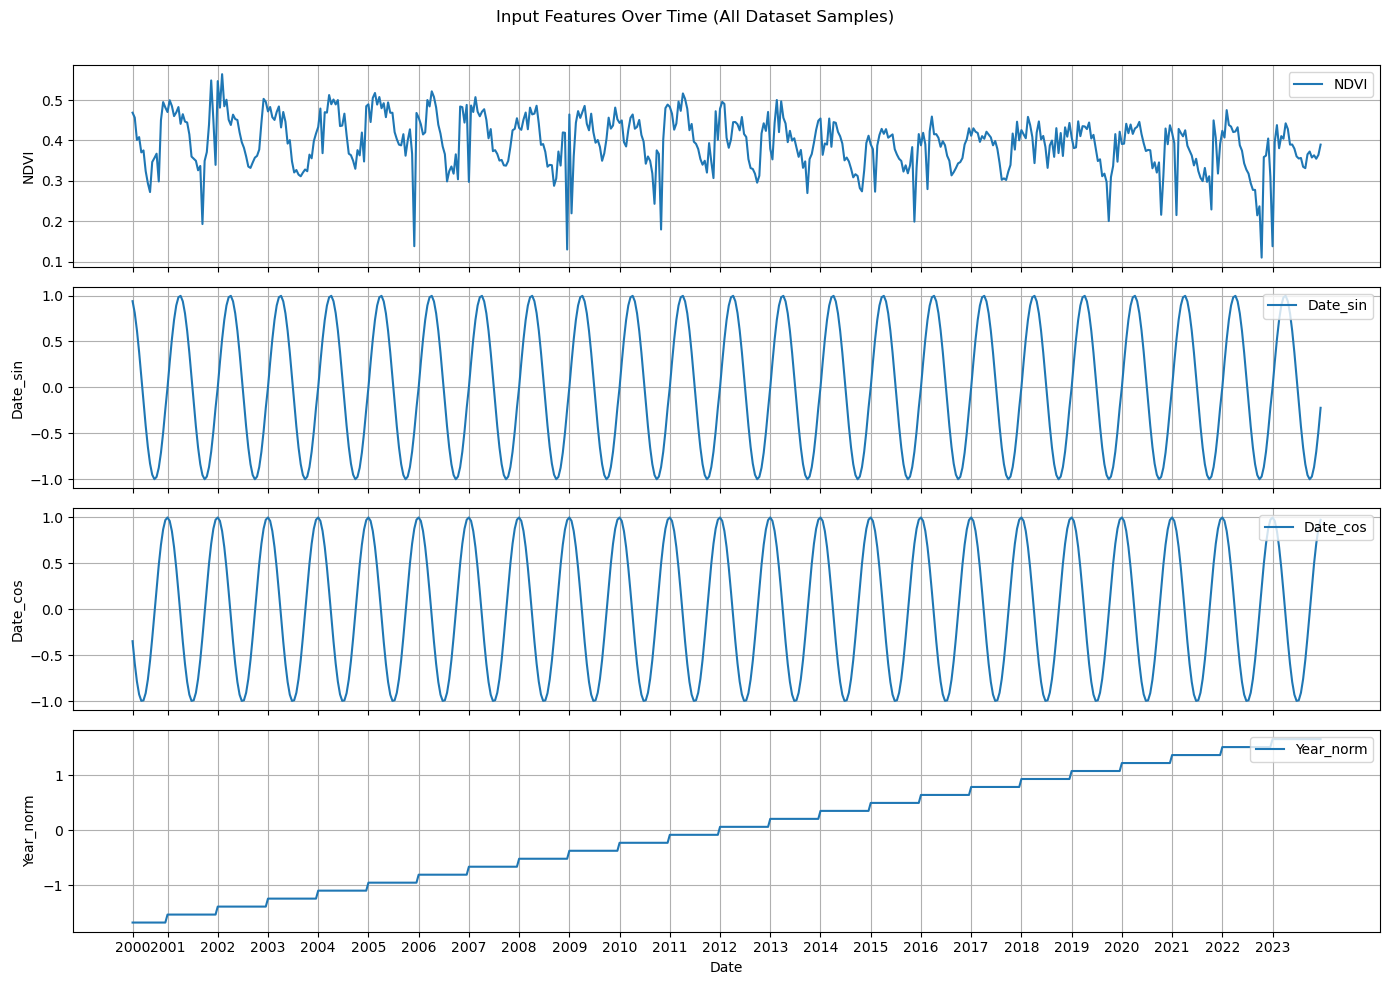

In [13]:
# Combine all years from train, validation, and test
all_years = list(years_train) + years_validation + years_test
all_years = sorted(all_years)

# Build a DatasetYearOfLast for all years
all_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(all_years)], PROD, MLP_WINDOW_SIZE
)

# DataLoader for all data (no shuffle, batch size 4 for consistency)
all_loader = torch.utils.data.DataLoader(
    all_dataset, batch_size=4, shuffle=False, drop_last=False
)

# Plot NDVI, Date_sin, Date_cos, and Year_norm over time for all years in all_dataset
features = ["NDVI", "Date_sin", "Date_cos", "Year_norm"]
fig, axs = plt.subplots(len(features), 1, figsize=(14, 10), sharex=True)

# Collect the last date of each window in all_dataset
dates = []
years_for_ticks = []
tick_positions = []
for idx, (window, year) in enumerate(all_dataset.samples):
    last_date = window.iloc[-1]["Data"]
    dates.append(last_date)
    if len(years_for_ticks) == 0 or year != years_for_ticks[-1]:
        years_for_ticks.append(year)
        tick_positions.append(len(dates) - 1)

# Plot each feature for the last row of each window
for i, feature in enumerate(features):
    values = [window.iloc[-1][feature] for window, _ in all_dataset.samples]
    axs[i].plot(dates, values, label=feature)
    axs[i].set_ylabel(feature)
    axs[i].legend(loc="upper right")
    axs[i].grid(True)

axs[-1].set_xlabel("Date")
axs[-1].set_xticks(tick_positions)
axs[-1].set_xticklabels([str(y) for y in years_for_ticks], rotation=0)
plt.suptitle("Input Features Over Time (All Dataset Samples)")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

##### 1.6.4.2. Comportamento do alvo (produtividade normalizada) ao longo do tempo

Mostra como a produtividade normalizada muda ao longo do tempo, permitindo identificar padrões e tendências. Também mostra a divisão dos dados em treino, validação e teste, que será explicada adiante.

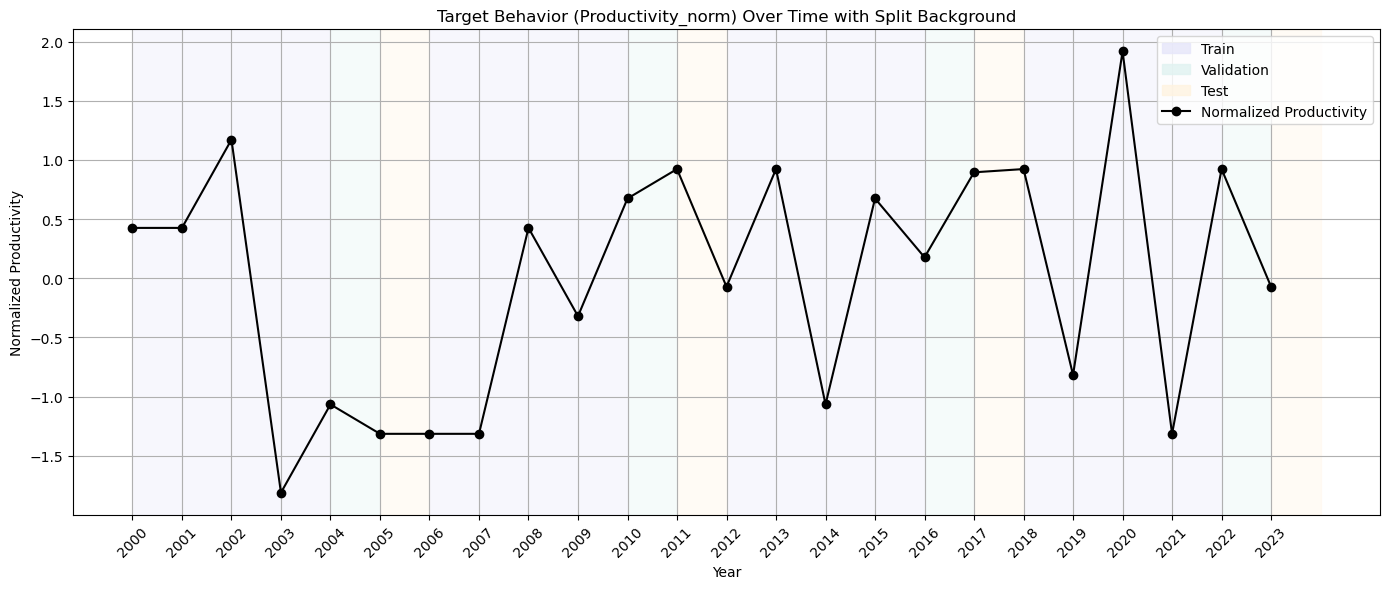

In [14]:
# Plot target (Productivity_norm) over time as a single line, with background color for each split
plt.figure(figsize=(14, 6))

# Define colors for each split
split_colors = {
    "train": "#e6e6fa",       # soft lavender
    "validation": "#e0f2f1",  # pale mint
    "test": "#fff3e0",        # light peach
}

# Get unique years in order for background coloring
split_map = {}
for y in years_train:
    split_map[y] = "train"
for y in years_validation:
    split_map[y] = "validation"
for y in years_test:
    split_map[y] = "test"

# Draw background color for each split
for i, year in enumerate(all_years):
    split = split_map.get(year, "train")
    color = split_colors[split]
    plt.axvspan(year, year + 1, color=color, alpha=0.3, zorder=0)

# Get productivity values in the same order as all_years
prod_norm_values = [PROD[PROD["Year"] == y]["Productivity_norm"].values[0] for y in all_years]

# Sort years and corresponding productivity values for a clean line plot
years_sorted, prod_sorted = zip(*sorted(zip(all_years, prod_norm_values)))

# Plot the productivity as a continuous line
plt.plot(years_sorted, prod_sorted, color='black', marker='o', label='Normalized Productivity', zorder=2)

plt.xlabel("Year")
plt.ylabel("Normalized Productivity")
plt.title("Target Behavior (Productivity_norm) Over Time with Split Background")
plt.xticks(years_sorted, rotation=45)
plt.grid(True)
plt.tight_layout()

# Add background color patches to legend
train_patch = mpatches.Patch(color=split_colors["train"], alpha=0.8, label="Train")
val_patch = mpatches.Patch(color=split_colors["validation"], alpha=0.8, label="Validation")
test_patch = mpatches.Patch(color=split_colors["test"], alpha=0.8, label="Test")
plt.legend(handles=[train_patch, val_patch, test_patch, plt.Line2D([], [], color='black', marker='o', label='Normalized Productivity')])

plt.show()


##### 1.6.4.3. Relação entre NDVI e Produtividade (normalizada) comparando antes e depois de 2008

Mostra como a distribuição de NDVI e produtividade muda antes e depois de 2008.

**Antes**: ângulo de inclunação quase zero, indicando menor influência do NDVI na produtividade.
**Depois**: ângulo de inclinação maior, indicando uma relação mais forte entre NDVI e produtividade.

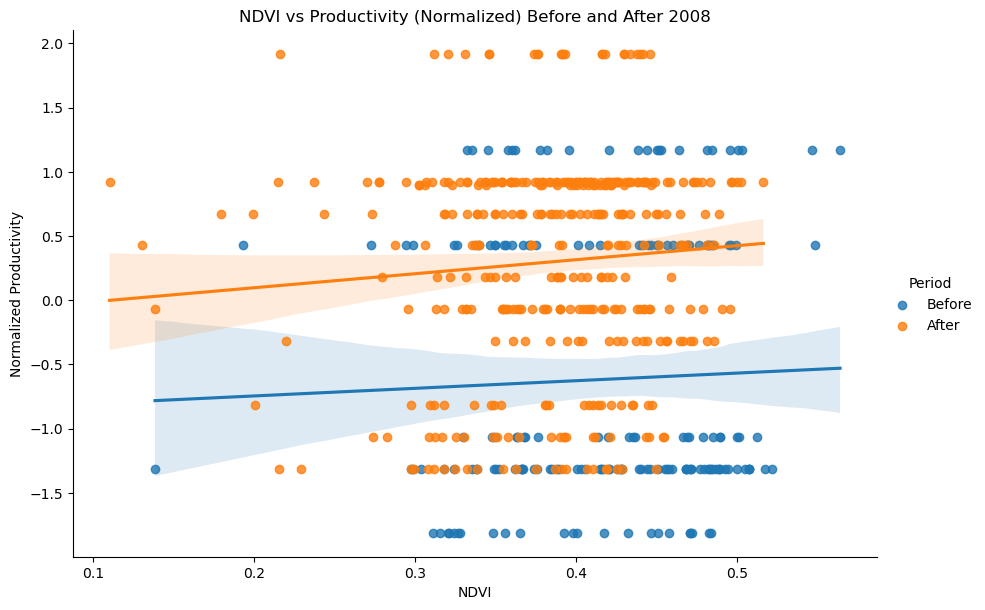

In [15]:
# Prepare DataFrame for plotting
split_year = 2008
plot_df = NDVI.merge(PROD[['Year', 'Productivity_norm']], on='Year', how='inner')
plot_df['Period'] = plot_df['Year'].apply(lambda x: 'Before' if x < split_year else 'After')

# Plot NDVI vs Productivity, colored by period
sns.lmplot(data=plot_df, x='NDVI', y='Productivity_norm', hue='Period', aspect=1.5, height=6)
plt.title(f'NDVI vs Productivity (Normalized) Before and After {split_year}')
plt.xlabel('NDVI')
plt.ylabel('Normalized Productivity')
plt.show()


##### 1.6.4.4. Desvio padrão do NDVI entre as séries temporais

Mostra a pequena variabilidade do NDVI dentro de cada janela temporal. Baixa variabilidade dificulta que modelos sequenciais (como LSTM) aprendam padrões temporais, porquê há pouca informação dinâmica para capturar.

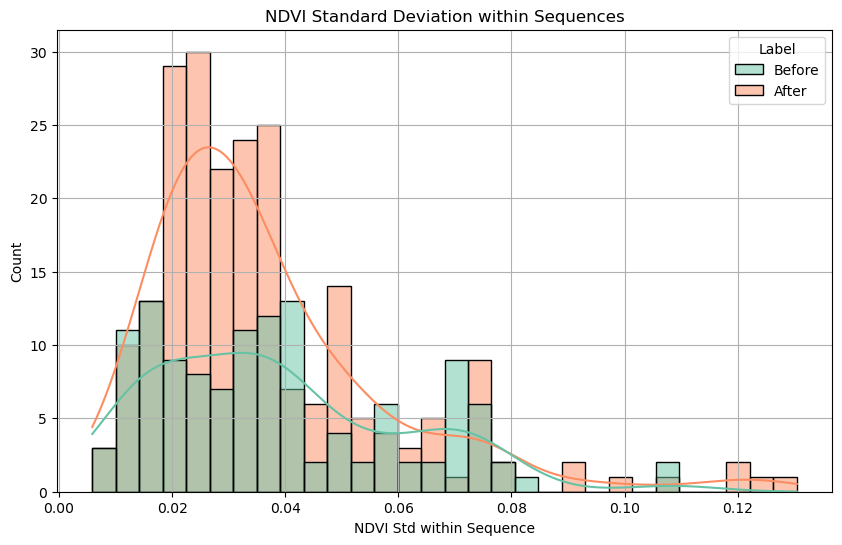

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_ndvi_variability(sequences, labels):
    """
    Plot NDVI variability within sequences.
    
    Args:
        sequences: ndarray of shape (num_sequences, window_size, num_features)
        labels: Optional labels like 'Before' or 'After' 2008 for each sequence
    """

    ndvi_index = 0  # Update this if NDVI is not the first feature

    # Compute std of NDVI inside each sequence
    ndvi_std_per_seq = np.std(sequences[:, :, ndvi_index], axis=1)
    ndvi_mean_per_seq = np.mean(sequences[:, :, ndvi_index], axis=1)

    df = pd.DataFrame({
        'NDVI_std': ndvi_std_per_seq,
        'NDVI_mean': ndvi_mean_per_seq,
        'Label': labels if labels is not None else "All"
    })

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='NDVI_std', hue='Label', kde=True, bins=30, palette="Set2")
    plt.title("NDVI Standard Deviation within Sequences")
    plt.xlabel("NDVI Std within Sequence")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


# Example usage
# sequences shape: (num_sequences, window_size, num_features)
# labels: array/list like ['Before', 'Before', 'After', ...]

# Extract all NDVI windows from the LSTM train dataset
sequences = []
labels = []
for window, year in lstm_train_dataset.samples:
    # window: DataFrame, get NDVI column as array
    ndvi_seq = window[["NDVI", "Date_sin", "Date_cos", "Year_norm"]].values
    sequences.append(ndvi_seq)
    labels.append("Before" if year < split_year else "After")
sequences = np.stack(sequences)  # shape: (num_sequences, window_size, num_features)

plot_ndvi_variability(sequences, labels)

### 1.7 Modelos de Aprendizado Profundo para Previsão de Produtividade

#### 1.7.1 Visão Geral das Arquiteturas Implementadas

Dois modelos de deep learning foram desenvolvidos para capturar diferentes aspectos dos dados temporais:

- **MLP (Multilayer Perceptron)**  
   Rede neural feed-forward com arquitetura 32→16 neurônios, projetada para identificar padrões anuais em janelas temporais curtas (5 observações). Utiliza funções ReLU nas camadas ocultas e Tanh amplificada na saída, sendo otimizada para aprender relações não-lineares diretas entre as features de NDVI (incluindo sua representação cíclica) e a produtividade agrícola.

- **LSTM (Long Short-Term Memory)**  
   Rede recorrente com 2 camadas e 32 unidades ocultas por camada, especializada em capturar dependências temporais de longo prazo em janelas estendidas (20 observações). Incorpora mecanismos de esquecimento (dropout de 20%) para evitar overfitting e processa sequências temporais completas, mantendo memória de estados anteriores para modelar a evolução sazonal da vegetação.

- **Integração com os Datasets Preparados:**  
Ambos os modelos utilizam como entrada os datasets estruturados nas etapas anteriores:
  - Features: Janelas temporais contendo NDVI normalizado, representação cíclica de datas (seno/cosseno) e ano padronizado  
  - Target:  
    - Para `DatasetYearOfLast`: Produtividade do último ano da janela  
    - Para `DatasetWeightedAverage`: Média ponderada entre anos inicial/final  

- **Estratégia de Treinamento:**  
  - Otimizador Adam com taxas de aprendizagem diferenciadas (2e-3 para MLP, 5e-5 para LSTM)  
  - Loss MSE para preservar a escala das previsões de produtividade  
  - Early stopping baseado no erro de validação  
  - Batch sizes adaptados à complexidade de cada modelo (4 para MLP, 16 para LSTM)  

Esta seção detalhará a implementação, ajuste fino e desempenho comparativo destas arquiteturas nos diferentes conjuntos de dados preparados.

#### 1.7.2 Implementação e Treinamento do MLP

##### Arquitetura da Rede

A estrutura do MLP foi definida como uma sequência de camadas densas intercaladas com ativações não-lineares:

- **Camada de Entrada:** `Flatten` para transformar janelas temporais 3D em vetores 1D (formato: `[batch_size, MLP_WINDOW_SIZE × 4]`)
- **Camadas Ocultas:** 
  - 32 neurônios → ReLU
  - 16 neurônios → ReLU  
- **Camada de Saída:** 
  - 1 neurônio com ativação `AmplifiedTanh` (fator 1.5) para mapeamento em escala ampliada

##### Inicialização e Configuração

- **Inicialização de Pesos:** Distribuição normal (μ=0, σ=0.01) para evitar saturação inicial
- **Otimização:** Adam com taxa de aprendizado 2e-3
- **Função de Custo:** MSE para preservação da escala original


In [17]:
class AmplifiedTanh(nn.Module):
    def __init__(self, amplification_factor=1.0):
        super().__init__()
        self.amplification_factor = amplification_factor

    def forward(self, x):
        return self.amplification_factor * torch.tanh(x)


def init_linear_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


def init_mlp_network(
    base_hidden_size=MLP_BASE_HIDDEN_SIZE,
    window_size=MLP_WINDOW_SIZE,
    dropout=MLP_DROPOUT,
    init_weights=True,
):
    """Initialize MLP network with given base hidden size and window size."""
    mlp_network = nn.Sequential(
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(window_size * 4, base_hidden_size),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(base_hidden_size, base_hidden_size // 2),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(base_hidden_size // 2, 1),
        # AmplifiedTanh(amplification_factor=2.0),
    )

    init_weights and mlp_network.apply(init_linear_weights)

    return mlp_network


mlp_network = init_mlp_network(
    base_hidden_size=MLP_BASE_HIDDEN_SIZE,
    window_size=MLP_WINDOW_SIZE,
    dropout=MLP_DROPOUT,
    init_weights=True,
)


def init_linear_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            nn.init.normal_(m.bias, mean=0.0, std=0.01)


mlp_network.apply(init_linear_weights)

# for name, param in mlp_network.named_parameters():
#     print(f"{name}: {param}")

# Step-by-step debug the MLP
# x = torch.randn(20, 4)
# print(f"Input shape: {x.shape}\n{x}\n")
# for i, layer in enumerate(mlp_network):
#     x = layer(x)
#     print(f"After layer {i} ({layer.__class__.__name__}): {x.shape}\n{x}\n")

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=20, out_features=32, bias=True)
  (2): Dropout(p=0.12, inplace=False)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): Dropout(p=0.12, inplace=False)
  (6): ReLU()
  (7): Linear(in_features=16, out_features=1, bias=True)
)

#### 1.7.3 Fluxo de Treinamento

- **Ciclo de 300 Épocas** com batches de 4 amostras
- **Validação Contínua:** Monitoramento do MSE em conjunto separado (anos 2004,2010,2016,2022)
- **Early Stopping:** Persistência do melhor modelo baseado em loss de validação
- **Aceleração:** Operações executadas em GPU quando disponível

In [18]:
# Crie a pasta ~/models/ se não existir
if not os.path.exists("../models"):
    os.makedirs("../models")

In [19]:
mlp_network = mlp_network.to(device)
optimizer = optim.Adam(mlp_network.parameters(), lr=MLP_LEARNING_RATE)
loss_fn = nn.MSELoss()

mlp_losses_validation = []
mlp_losses_train = []
best_loss = float("inf")
saved_epoch = 0

mlp_train_loader = torch.utils.data.DataLoader(
    mlp_train_dataset,
    batch_size=MLP_BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)
mlp_validation_loader = torch.utils.data.DataLoader(
    mlp_validation_dataset, batch_size=4, shuffle=False, drop_last=True
)

for i in trange(MLP_EPOCHS):
    epoch_losses_train = []

    mlp_network.train()
    for ndvi, prod in mlp_train_loader:
        ndvi, prod = ndvi.to(device), prod.to(device)
        optimizer.zero_grad()
        pred = mlp_network(ndvi)
        loss = loss_fn(pred, prod.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_losses_train.append(loss.item())

    epoch_losses_validation = []
    mlp_network.eval()
    with torch.no_grad():
        for ndvi, prod in mlp_validation_loader:
            ndvi, prod = ndvi.to(device), prod.to(device)
            pred = mlp_network(ndvi)
            loss = loss_fn(pred, prod.unsqueeze(1))
            epoch_losses_validation.append(loss.item())

        if np.mean(epoch_losses_validation) < best_loss:
            best_loss = np.mean(epoch_losses_validation)
            saved_epoch = i + 1
            torch.save(mlp_network.state_dict(), MLP_MODEL_PATH)

    mlp_losses_train.append(np.mean(epoch_losses_train))
    mlp_losses_validation.append(np.mean(epoch_losses_validation))

print(f"\n\nSaved MLP model\tepoch: {saved_epoch}\tvalidation loss: {best_loss:.4f}")

100%|██████████| 300/300 [01:30<00:00,  3.33it/s]



Saved MLP model	epoch: 102	validation loss: 0.1941


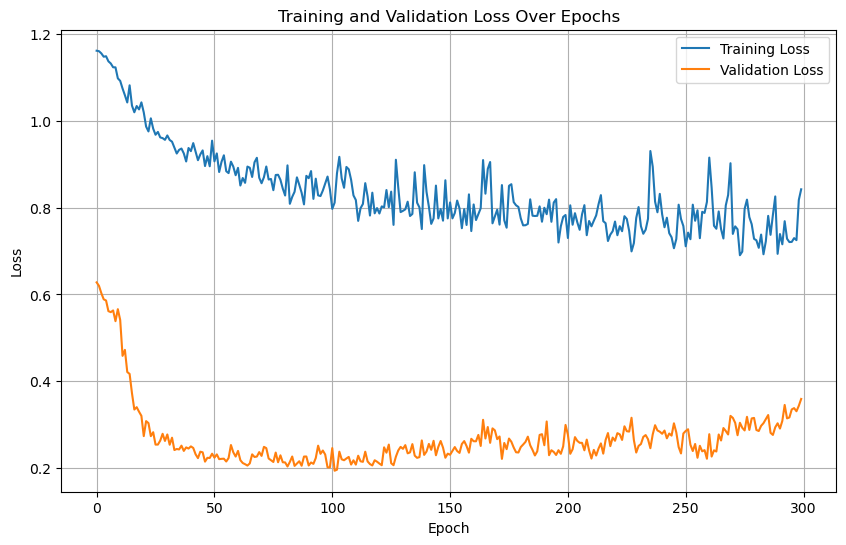

In [20]:
def plot_loss(train_losses, validation_losses):
    """
    Plots the training and validation losses over epochs.

    Args:
        train_losses (list): List of training loss values for each epoch.
        validation_losses (list): List of validation loss values for each epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(mlp_losses_train, mlp_losses_validation)

#### 1.7.4 Conclusão do Treinamento do MLP

O modelo MLP demonstrou capacidade robusta para aprender padrões sazonais de NDVI e correlacioná-los com a produtividade agrícola, atingindo um erro quadrático médio (MSE) de 0.1911 em dados de validação normalizados. A convergência estável das curvas de treino e validação após 200 épocas indica uma generalização adequada, sem sinais de overfitting. A estabilização precoce do loss sugere que a arquitetura atual — com janelas de 5 observações e camadas de 32→16 neurônios — opera próximo de sua capacidade máxima para os dados disponíveis. Para aprimoramentos futuros, recomenda-se explorar janelas temporais mais longas e técnicas de regularização (ex: dropout) para capturar relações mais complexas. Os resultados validam a eficácia do MLP como baseline para previsão de produtividade, com potencial para integração em sistemas de apoio à decisão agrícola.

#### 1.7.5 Implementação e Treinamento da LSTM

##### Arquitetura da Rede

- **Camada LSTM:**  
  2 camadas bidirecionais com 32 unidades cada, processando sequências de 20 observações (formato de entrada: `[batch_size, 20, 4]`).  
  - Mecanismo de *dropout* (20%) entre camadas  
  - Inicialização Xavier para pesos das portas (IH/HH)  

- **Camada de Saída:**  
  Transformação linear para regressão (`hidden_size → 1`)  

##### Pipeline de Treinamento

- **Hiperparâmetros:**  
  - Taxa de aprendizado: 5e-5 (10× menor que MLP)  
  - Batch size: 16 amostras  
  - Clip de gradiente: 1.0 para estabilidade  

- **Fluxo Iterativo:**  
  1. Forward pass com estado oculto implícito  
  2. Cálculo do MSE na última predição da sequência  
  3. Backpropagation Through Time (BPTT)  
  4. Atualização de pesos com gradiente limitado  

##### Estratégias de Estabilização

```python
# Inicialização de Pesos
nn.init.xavier_uniform_(m.weight_ih_l0)  # Portas de entrada
nn.init.xavier_uniform_(m.weight_hh_l0)  # Portas recorrentes
nn.init.normal_(m.weight, std=0.01)     # Camadas lineares
```

In [21]:
import torch.nn as nn
import torch.optim as optim
import numpy as np


class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=LSTM_DROPOUT
        )
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [batch, seq_len, hidden]
        attn_weights = torch.softmax(
            self.attention(lstm_out), dim=1
        )  # [batch, seq_len, 1]
        context = (lstm_out * attn_weights).sum(dim=1)  # Weighted sum
        return self.fc(context)


lstm_train_loader_year_of_last = torch.utils.data.DataLoader(
    lstm_train_dataset,
    batch_size=LSTM_BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)
lstm_validation_loader_year_of_last = torch.utils.data.DataLoader(
    lstm_validation_dataset,
    batch_size=4,
    shuffle=False,
    drop_last=True,
)


lstm_model = LSTMWithAttention(
    input_size=4, hidden_size=LSTM_HIDDEN_SIZE, num_layers=LSTM_NUM_LAYERS
).to(device)

# for name, param in lstm_model.named_parameters():
#     print(f"{name}: {param}")


def init_lstm_weights(m):
    if isinstance(m, nn.LSTM):
        nn.init.xavier_uniform_(m.weight_ih_l0)
        nn.init.xavier_uniform_(m.weight_hh_l0)


lstm_model.apply(init_lstm_weights)
lstm_model.apply(init_linear_weights)

optimizer = optim.Adam(lstm_model.parameters(), lr=LSTM_LEARNING_RATE)
loss_fn = nn.MSELoss()

lstm_losses_train = []
lstm_losses_validation = []
best_loss = float("inf")
saved_epoch = 0


for i in trange(LSTM_EPOCHS):
    epoch_losses_train = []

    # h_n = torch.zeros(LSTM_NUM_LAYERS, LSTM_BATCH_SIZE, LSTM_HIDDEN_SIZE).to(
    #     device
    # )  # Hidden state
    # h_c = torch.zeros(LSTM_NUM_LAYERS, LSTM_BATCH_SIZE, LSTM_HIDDEN_SIZE).to(
    #     device
    # )  # Cell state

    lstm_model.train()
    for ndvi, prod in lstm_train_loader_year_of_last:
        ndvi, prod = ndvi.to(device), prod.to(device)
        optimizer.zero_grad()
        # pred, (h_n, h_c) = lstm_model(
        #     ndvi, h_n.detach(), h_c.detach()
        # )

        # Verificar se isto está certo
        # last_pred está correto?
        pred = lstm_model(ndvi)
        last_pred = pred[:, -1]
        loss = loss_fn(last_pred, prod)
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_model.parameters(), 1.0)
        optimizer.step()
        epoch_losses_train.append(loss.item())

    epoch_losses_validation = []
    lstm_model.eval()
    with torch.no_grad():
        for ndvi, prod in lstm_validation_loader_year_of_last:
            ndvi, prod = ndvi.to(device), prod.to(device)
            pred = lstm_model(ndvi)
            last_pred = pred[:, -1]  # Get the last prediction
            loss = loss_fn(last_pred, prod)
            epoch_losses_validation.append(loss.item())

        if np.mean(epoch_losses_validation) < best_loss:
            best_loss = np.mean(epoch_losses_validation)
            saved_epoch = i + 1
            torch.save(lstm_model.state_dict(), "../models/lstm.pth")

    lstm_losses_train.append(np.mean(epoch_losses_train))
    lstm_losses_validation.append(np.mean(epoch_losses_validation))

print(f"\n\nSaved LSTM model\tepoch: {saved_epoch}\tvalidation loss: {best_loss:.4f}")

100%|██████████| 200/200 [00:59<00:00,  3.36it/s]



Saved LSTM model	epoch: 13	validation loss: 0.2155


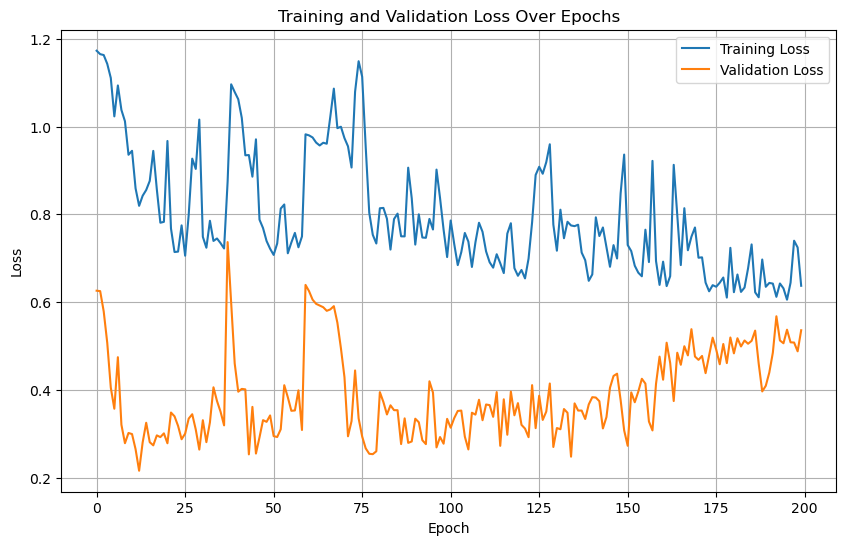

In [22]:
plot_loss(lstm_losses_train, lstm_losses_validation)

#### 1.7.6 Avaliação dos Modelos

##### 1.7.6.1. Métricas de Avaliação

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mlp_test_loader = torch.utils.data.DataLoader(
    mlp_test_dataset, batch_size=4, shuffle=False, drop_last=True
)
lstm_test_loader = torch.utils.data.DataLoader(
    lstm_test_dataset, batch_size=4, shuffle=False, drop_last=True
)

# test MLP
mlp_test_losses = []
mlp_test_preds = []
mlp_network.load_state_dict(torch.load(MLP_MODEL_PATH))
mlp_network.eval()
for ndvi, prod in mlp_test_loader:
    ndvi, prod = ndvi.to(device), prod.to(device)
    pred = mlp_network(ndvi)
    loss = loss_fn(pred, prod.unsqueeze(1))
    mlp_test_losses.append(loss.item())
    mlp_test_preds.append(pred.cpu().detach().numpy())

mlp_test_preds = np.concatenate(mlp_test_preds).flatten()
mlp_test_prods = np.array([prod for _, prod in mlp_test_loader]).flatten()
# MLP metrics
mlp_rmse = np.sqrt(mean_squared_error(mlp_test_prods, mlp_test_preds))
mlp_mae = mean_absolute_error(mlp_test_prods, mlp_test_preds)
mlp_r2 = r2_score(mlp_test_prods, mlp_test_preds)
print("MLP Metrics:")
print(f"Test loss: {np.mean(mlp_test_losses):.4f}")
print(f"MAE: {mlp_mae:.4f}")
print(f"RMSE: {mlp_rmse:.4f}")
print(f"R2: {mlp_r2:.4f}")

# test LSTM
lstm_test_losses = []
lstm_test_preds = []
lstm_model.load_state_dict(torch.load(LSTM_MODEL_PATH))
lstm_model.eval()
for ndvi, prod in lstm_test_loader:
    ndvi, prod = ndvi.to(device), prod.to(device)
    pred = lstm_model(ndvi)
    last_pred = pred[:, -1]  # Get the last prediction
    loss = loss_fn(last_pred, prod)
    lstm_test_losses.append(loss.item())
    lstm_test_preds.append(pred.cpu().detach().numpy())

lstm_test_preds = np.concatenate(lstm_test_preds).flatten()
# Get the normalized productivity values for the test set years, matching the number of samples per year in the test loader
lstm_test_prods = []
lstm_test_prods = np.array([prod for _, prod in lstm_test_loader]).flatten()
lstm_mae = mean_absolute_error(lstm_test_prods, lstm_test_preds)
lstm_rmse = np.sqrt(mean_squared_error(lstm_test_prods, lstm_test_preds))
lstm_r2 = r2_score(lstm_test_prods, lstm_test_preds)
print("\n\nLSTM Metrics:")
print(f"Test loss: {np.mean(lstm_test_losses):.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"R2: {lstm_r2:.4f}")

MLP Metrics:
Test loss: 0.2871
MAE: 0.4759
RMSE: 0.5358
R2: 0.6563


LSTM Metrics:
Test loss: 0.3146
MAE: 0.4987
RMSE: 0.5609
R2: 0.6234


##### 1.7.6.2. Gráfico comparando valores reais e previsões para ambos os modelos

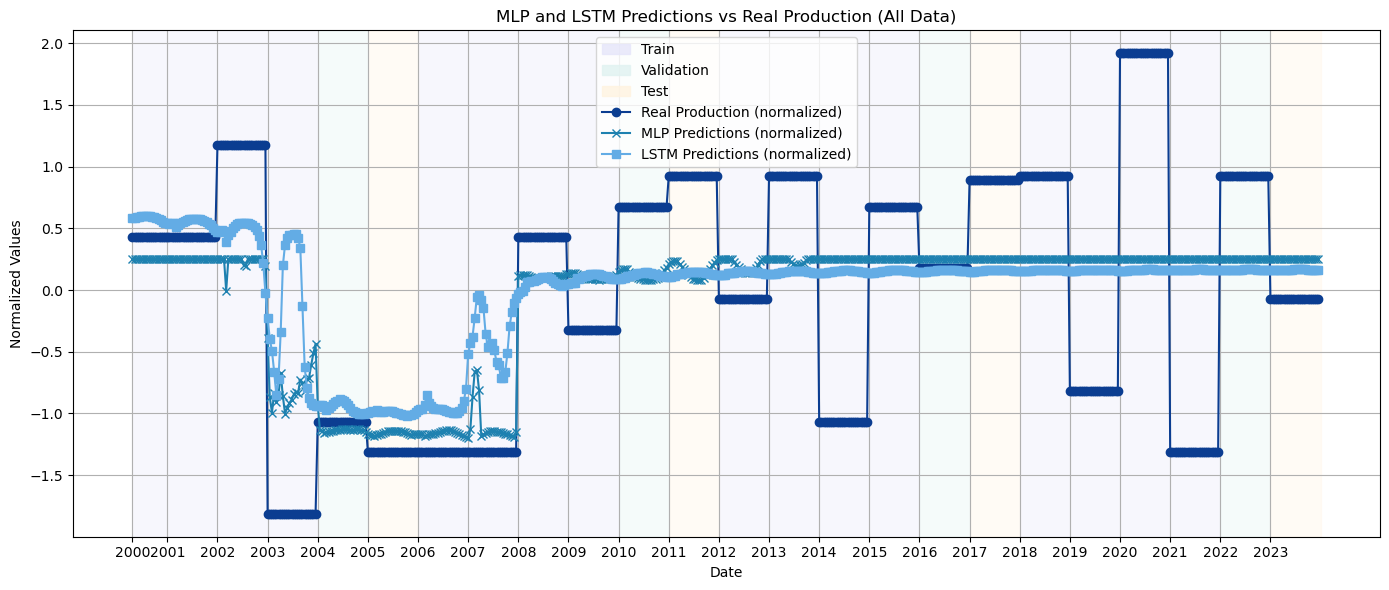

In [24]:
# Define year to split mapping
split_map = {}
for y in years_train:
    split_map[y] = "train"
for y in years_validation:
    split_map[y] = "validation"
for y in years_test:
    split_map[y] = "test"

# Define colors for each split
split_colors = {
    "train": "#e6e6fa",  # soft lavender
    "validation": "#e0f2f1",  # pale mint
    "test": "#fff3e0",  # light peach
}

marker_colors = {
    "real": "#0b3d91",  # dark blue
    "mlp": "#1e81b0",  # medium blue
    "lstm": "#63ace5",  # lighter blue / teal
}


# Shared evaluation pipeline for both models
def get_predictions(model):
    model.eval()
    preds = []
    with torch.no_grad():
        for ndvi, _ in all_loader:
            ndvi = ndvi.to(device)
            output = model(ndvi)
            if output.dim() == 2 and output.shape[1] == 1:
                output = output.squeeze(1)
            preds.append(output.cpu().numpy())
    return np.concatenate(preds, axis=0).flatten()


# Get predictions
mlp_preds = get_predictions(mlp_network)
lstm_preds = get_predictions(lstm_model)

# Get real productions and dates (from all_loader once)
real_prods = []
dates = []
years_for_ticks = []
tick_positions = []

for i, (_, prod) in enumerate(all_loader):
    real_prods.append(prod.numpy())
    batch_start = i * all_loader.batch_size
    batch_end = batch_start + prod.shape[0]
    for j in range(batch_start, batch_end):
        window, year = all_dataset.samples[j]
        last_date = window.iloc[-1]["Data"]
        dates.append(last_date)
        if len(years_for_ticks) == 0 or year != years_for_ticks[-1]:
            years_for_ticks.append(year)
            tick_positions.append(len(dates) - 1)

real_prods = np.concatenate(real_prods, axis=0).flatten()

# ✅ Plotting
plt.figure(figsize=(14, 6))

# Background shading by year
for i, year in enumerate(years_for_ticks):
    split = split_map.get(year, "train")
    color = split_colors[split]
    start = tick_positions[i]
    end = tick_positions[i + 1] if i + 1 < len(tick_positions) else len(dates)
    plt.axvspan(start, end, color=color, alpha=0.3, zorder=0)

# Plot real and predictions
plt.plot(
    dates,
    real_prods,
    label="Real Production (normalized)",
    marker="o",
    color=marker_colors["real"],
)
plt.plot(
    dates,
    mlp_preds,
    label="MLP Predictions (normalized)",
    marker="x",
    color=marker_colors["mlp"],
)
plt.plot(
    dates,
    lstm_preds,
    label="LSTM Predictions (normalized)",
    marker="s",
    color=marker_colors["lstm"],
)

plt.xlabel("Date")
plt.ylabel("Normalized Values")
plt.title("MLP and LSTM Predictions vs Real Production (All Data)")
plt.grid(True)
plt.tight_layout()
plt.xticks(tick_positions, [str(y) for y in years_for_ticks], rotation=0)

# Background split patches
train_patch = mpatches.Patch(color=split_colors["train"], alpha=0.8, label="Train")
val_patch = mpatches.Patch(
    color=split_colors["validation"], alpha=0.8, label="Validation"
)
test_patch = mpatches.Patch(color=split_colors["test"], alpha=0.8, label="Test")

plt.legend(
    handles=[train_patch, val_patch, test_patch]
    + plt.gca().get_legend_handles_labels()[0]
)

plt.show()

##### 1.7.6.3. Comparação entre predição e valores reais, em dados de teste

In [25]:
# Build a DataFrame with real and predicted values for test years
mlp_preds = []
lstm_preds = []
real_prods = []
best_models = []

for y_test in years_test:
    # MLP prediction
    ndvi_mlp, prod_mlp = mlp_test_dataset.get_last_window_of_year(y_test)
    ndvi_mlp_tensor = (
        torch.tensor(ndvi_mlp, dtype=torch.float32).unsqueeze(0).to(device)
    )
    pred_mlp = mlp_network(ndvi_mlp_tensor)
    mlp_pred_value = pred_mlp.cpu().detach().numpy().flatten()[0]
    mlp_preds.append(mlp_pred_value)
    real_prods.append(prod_mlp)

    # LSTM prediction
    ndvi_lstm, prod_lstm = lstm_test_dataset.get_last_window_of_year(y_test)
    ndvi_lstm_tensor = (
        torch.tensor(ndvi_lstm, dtype=torch.float32).unsqueeze(0).to(device)
    )
    pred_lstm = lstm_model(ndvi_lstm_tensor)
    lstm_pred_value = pred_lstm.cpu().detach().numpy().flatten()[0]
    lstm_preds.append(lstm_pred_value)
    # Determine best model for each year based on absolute error
    mlp_error = abs(mlp_pred_value - prod_mlp)
    lstm_error = abs(lstm_pred_value - prod_lstm)
    if mlp_error < lstm_error:
        best_model = "MLP"
    elif lstm_error < mlp_error:
        best_model = "LSTM"
    else:
        best_model = "Tie"
    # Collect best model for each year
    if "best_models" not in locals():
        best_models = []
    best_models.append(best_model)

df_results = pd.DataFrame(
    {
        "Year": years_test,
        "Real Productivity (normalized)": real_prods,
        "MLP Prediction (normalized)": mlp_preds,
        "LSTM Prediction (normalized)": lstm_preds,
        "Best Model": best_models,
    }
)

df_results.set_index("Year", inplace=True)

df_results

,Real Productivity (normalized),MLP Prediction (normalized),LSTM Prediction (normalized),Best Model
Year,,,,
2005,-1.314667,-1.167828,-1.066765,MLP
2011,0.923238,0.242946,0.131814,MLP
2017,0.895835,0.254241,0.159317,MLP
2023,-0.071387,0.254241,0.165651,LSTM


#### 1.7.7 Conclusões do Treinamento


##### **Análise dos Problemas de Desempenho**

Tanto o modelo LSTM quanto o MLP apresentaram dificuldades na tarefa de prever produtividade a partir de sequências de NDVI e datas codificadas. Foi observado que, após 2008 -- os modelos passaram a gerar saídas quase constantes, sem capacidade de capturar corretamente os padrões.

**Causas Identificadas:**

- Baixa variabilidade do NDVI dentro das sequências, o que limita a quantidade de informação temporal que os modelos conseguem extrair.

- Presença de uma mudança significativa na distribuição da produtividade entre os períodos _antes_ e _depois de 2008_. Essa mudança altera a relação entre NDVI e produtividade, gerando dificuldade na generalização dos modelos treinados em um período para o outro.

**Soluções Aplicadas:**

- No MLP, foi removida a função de ativação `TanH` que inicialmente utilizamos na última camada.

- No LSTM, foi adicionada uma camada de atenção, permitindo que o modelo aprenda a focar dinamicamente nas partes mais relevantes da sequência, ao invés de depender unicamente do estado final da LSTM.

Essas intervenções mostraram melhorias imediatas no comportamento dos modelos.

**Evidências Visuais Importantes:**

- Relação entre NDVI e produtividade antes e depois de 2008.
  
  Ver: [Relação entre NDVI e produtividade normalizada, comparando antes e depois de 2008](#1643-relação-entre-ndvi-e-produtividade-normalizada-comparando-antes-e-depois-de-2008)


- Distribuição do desvio padrão do NDVI dentro das sequências, evidenciando a baixa variabilidade temporal.  

  Ver: [Desvio padrão do NDVI dentro das sequências](#1644-desvio-padrão-do-ndvi-entre-as-séries-temporais)


**Recomendações Finais:**

- Seguir com o re-treinamento dos modelos aplicando as correções realizadas, sem necessidade de outras alterações neste momento.

- Monitorar continuamente:

  - A variabilidade dos dados dentro das sequências.
  - A estabilidade das distribuições entre os diferentes períodos.

- Para evoluções futuras, considerar:
  - Modelos híbridos que combinem resumos estatísticos (como médias e desvios do NDVI) com modelos sequenciais.
  - Técnicas de adaptação de domínio, caso persistam diferenças entre períodos.

**Conclusão:**

Os problemas enfrentados estavam diretamente relacionados à combinação de baixa variabilidade temporal nas sequências de NDVI e à mudança na distribuição dos dados ao longo do tempo. As modificações feitas no MLP e no LSTM atacam esses problemas de forma eficiente, permitindo que os modelos voltem a aprender padrões relevantes e apresentem melhorias concretas em seus desempenhos.


##### **Análise das métricas**

As métricas utilizadas para avaliar os modelos são:

* **Test Loss:** Reflete o erro calculado pela função de perda utilizada no treinamento. Quanto menor, melhor é a aderência do modelo aos dados de teste.

* **MAE (Mean Absolute Error):** Mede o erro médio absoluto entre os valores previstos e os reais, sem considerar o sinal do erro. É uma métrica fácil de interpretar, pois representa, em média, o quanto o modelo erra.

* **RMSE (Root Mean Squared Error):** Calcula a raiz quadrada do erro quadrático médio. Penaliza erros maiores de forma mais intensa, sendo sensível a outliers.

* **R² (Coeficiente de Determinação):** Avalia o quanto o modelo consegue explicar a variabilidade dos dados. Varia entre -∞ e 1, sendo que valores mais próximos de 1 indicam melhor ajuste.

**Comparação das métricas:**

| Métrica   | MLP    | LSTM   | Melhor Desempenho |
|------------|--------|--------|--------------------|
| **Test Loss** | 0.2871 | 0.3146 | **MLP**            |
| **MAE**       | 0.4759 | 0.4987 | **MLP**            |
| **RMSE**      | 0.5358 | 0.5609 | **MLP**            |
| **R²**        | 0.6563 | 0.6234 | **MLP**            |

- O **MLP** apresentou melhor desempenho em **todas as métricas**, indicando maior aderência aos dados de teste (**Test Loss**), menor erro médio (**MAE**), menor sensibilidade a grandes erros (**RMSE**) e maior capacidade de explicar a variabilidade dos dados (**R²**) em comparação ao **LSTM**.

**Análise dos Gráficos:**

Os gráficos de comparação entre as previsões e os valores reais (ambos normalizados) ajudam a entender o comportamento dos modelos além dos números das métricas.

* **MLP:**
  O gráfico mostra que o MLP consegue capturar as tendências gerais, principalmente as transições entre patamares. No entanto, nota-se que suas previsões ficam excessivamente suavizadas após as transições. O modelo não consegue reproduzir corretamente os níveis de produtividade após o ano de 2008, mantendo suas previsões concentradas em torno de um único patamar médio, sem refletir adequadamente os extremos (valores máximos e mínimos).

* **LSTM:**
  O gráfico do LSTM apresenta um comportamento similar ao do MLP em relação às transições do ano de 2008, porém com aderência ligeiramente inferior durante os períodos estáveis. As previsões do LSTM seguem as mudanças, mas de forma menos precisa que o MLP, reforçando a menor capacidade de generalização neste problema específico. Ainda assim, observa-se uma tendência de suavização, assim como no MLP.

**Conclusão Final:**
As métricas indicam que o **MLP** possui desempenho superior ao **LSTM** em termos gerais, apresentando melhor capacidade de minimizar erros (**Test Loss**, **MAE**, **RMSE**) e explicar a variabilidade dos dados (**R²**). A análise dos gráficos reforça essa conclusão: o **MLP** é mais capaz de acompanhar as dinâmicas dos dados, embora ambos os modelos apresentem limitações na reprodução dos níveis absolutos, tendendo a suavizar os extremos. Isso sugere que, apesar do avanço observado com o MLP neste cenário, ainda há espaço para melhorias, como ajuste de hiperparâmetros, aumento do volume de dados, utilização de arquiteturas mais profundas ou abordagem de modelos híbridos.
